# Time series - TensorFlow

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from pathlib import Path

import os, sys
sys.path.insert(0, os.path.abspath('../src'))

from ts import *
from utils import *

In [2]:
data_path = "../data"

In [3]:
DataDownloader(data_path).download_all_csv()

In [4]:
covidpro_df, dpc_regioni_df, _, _, _ = load_data(data_path)

In [5]:
import tensorflow as tf

In [6]:
province = "Firenze"
compart = "New_cases"
date = 'Date'

In [7]:
df = covidpro_df[covidpro_df.Province == province].query('20200801 > Date')

In [8]:
df = df.set_index(date)

In [9]:
df = df.loc[:, ['New_cases', 'Deaths']]

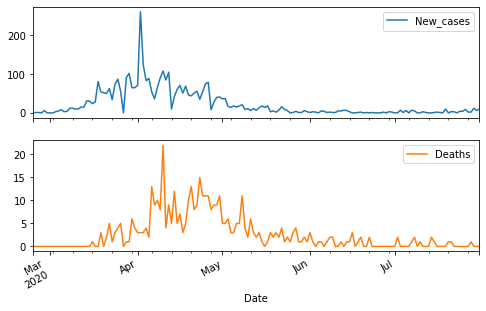

In [10]:
df.plot(subplots=True, figsize=(8,5))
plt.show()

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
New_cases,159.0,22.817610,34.652498,0.0,1.0,7.0,35.5,261.0
Deaths,159.0,2.622642,3.742806,0.0,0.0,1.0,3.5,22.0


In [12]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [13]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [14]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):
        
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                          enumerate(label_columns)}

        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    def plot(self, model=None, plot_col='New_cases', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)
        
            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index
        
            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()
        
        plt.xlabel('Days')
        plt.show()

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32)
        
        ds = ds.map(self.split_window)
        
        return ds
    
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [15]:
# Create a window for a single prediction 7 days
# into the future, given 14 days of history
w1 = WindowGenerator(input_width=14, label_width=1, shift=7,
                     label_columns=['New_cases'])
w1

Total window size: 21
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label indices: [20]
Label column name(s): ['New_cases']

In [16]:
w2 = WindowGenerator(input_width=30, label_width=1, shift=7,
                     label_columns=['New_cases'])
w2

Total window size: 37
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [36]
Label column name(s): ['New_cases']

In [17]:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[10:10+w2.total_window_size]),
                           np.array(train_df[20:20+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

In [18]:
w2._example = example_inputs, example_labels

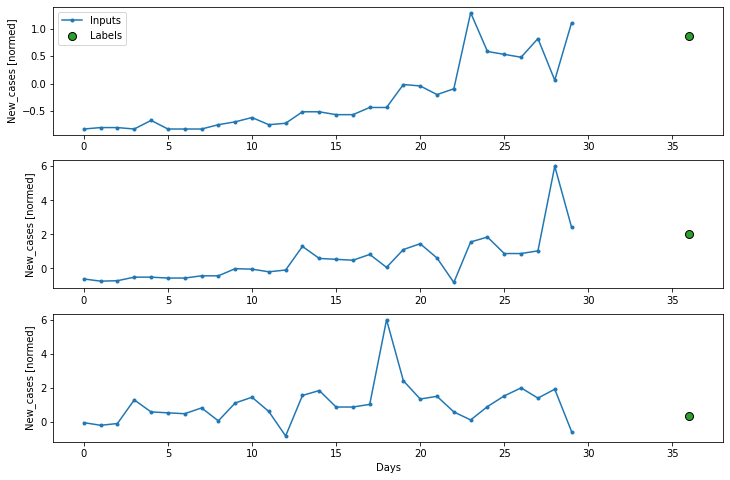

In [19]:
w2.plot()

In [20]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 30, 2), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [21]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 30, 2)
Labels shape (batch, time, features): (32, 1, 1)


## Single step

In [22]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=[compart])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['New_cases']

In [23]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 2)
Labels shape (batch, time, features): (32, 1, 1)


In [24]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
    
    def call(self, inputs):
        if self.label_index is None:
            return inputs
            
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [25]:
baseline = Baseline(label_index=column_indices[compart])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

1/1 [==============================] - 0s 841us/step - loss: 0.0064 - mean_absolute_error: 0.0582


In [26]:
wide_window = WindowGenerator(
    input_width=14, label_width=14, shift=1,
    label_columns=[compart])

wide_window

Total window size: 15
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Label column name(s): ['New_cases']

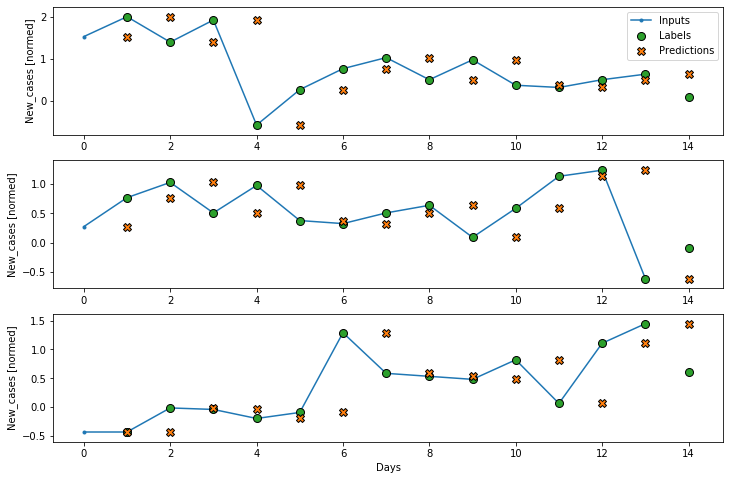

In [27]:
wide_window.plot(baseline)

In [28]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [29]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [30]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
4/4 [==============================] - 0s 32ms/step - loss: 0.9388 - mean_absolute_error: 0.7457 - val_loss: 0.6271 - val_mean_absolute_error: 0.7893
Epoch 2/20
4/4 [==============================] - 0s 19ms/step - loss: 0.9314 - mean_absolute_error: 0.7412 - val_loss: 0.6179 - val_mean_absolute_error: 0.7835
Epoch 3/20
4/4 [==============================] - 0s 17ms/step - loss: 0.9235 - mean_absolute_error: 0.7368 - val_loss: 0.6102 - val_mean_absolute_error: 0.7786
Epoch 4/20
4/4 [==============================] - 0s 16ms/step - loss: 0.9161 - mean_absolute_error: 0.7327 - val_loss: 0.6019 - val_mean_absolute_error: 0.7733
Epoch 5/20
4/4 [==============================] - 0s 16ms/step - loss: 0.9091 - mean_absolute_error: 0.7287 - val_loss: 0.5932 - val_mean_absolute_error: 0.7677
Epoch 6/20
4/4 [==============================] - 0s 15ms/step - loss: 0.9021 - mean_absolute_error: 0.7246 - val_loss: 0.5849 - val_mean_absolute_error: 0.7622
Epoch 7/20
4/4 [==================

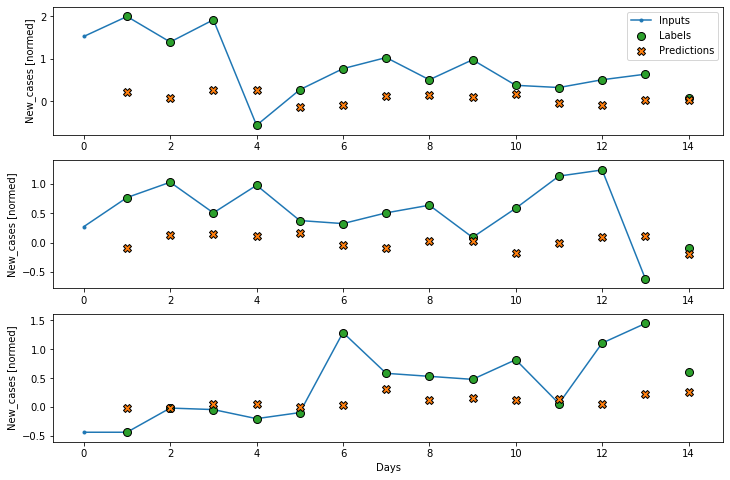

In [31]:
wide_window.plot(linear)

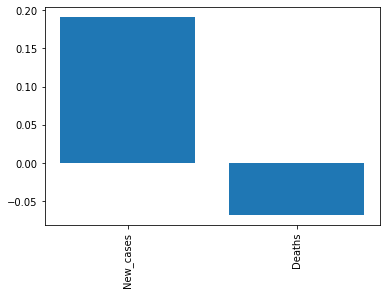

In [32]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
axis.set_xticklabels(train_df.columns, rotation=90)
plt.show()

In [33]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
4/4 [==============================] - 0s 38ms/step - loss: 0.9381 - mean_absolute_error: 0.7463 - val_loss: 0.6651 - val_mean_absolute_error: 0.8136
Epoch 2/20
4/4 [==============================] - 0s 14ms/step - loss: 0.8135 - mean_absolute_error: 0.6811 - val_loss: 0.5648 - val_mean_absolute_error: 0.7494
Epoch 3/20
4/4 [==============================] - 0s 15ms/step - loss: 0.7459 - mean_absolute_error: 0.6319 - val_loss: 0.4871 - val_mean_absolute_error: 0.6957
Epoch 4/20
4/4 [==============================] - 0s 18ms/step - loss: 0.6825 - mean_absolute_error: 0.5904 - val_loss: 0.4126 - val_mean_absolute_error: 0.6398
Epoch 5/20
4/4 [==============================] - 0s 17ms/step - loss: 0.6390 - mean_absolute_error: 0.5561 - val_loss: 0.3434 - val_mean_absolute_error: 0.5831
Epoch 6/20
4/4 [==============================] - 0s 19ms/step - loss: 0.6026 - mean_absolute_error: 0.5278 - val_loss: 0.2824 - val_mean_absolute_error: 0.5280
Epoch 7/20
4/4 [==================

In [34]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=[compart])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['New_cases']

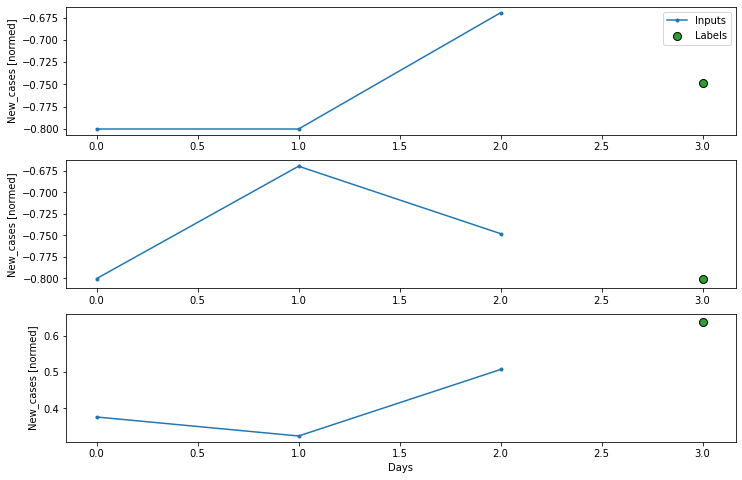

In [35]:
conv_window.plot()

In [36]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [37]:
history = compile_and_fit(multi_step_dense, conv_window)

val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

Epoch 1/20
4/4 [==============================] - 0s 42ms/step - loss: 0.9593 - mean_absolute_error: 0.7143 - val_loss: 0.6019 - val_mean_absolute_error: 0.7719
Epoch 2/20
4/4 [==============================] - 0s 17ms/step - loss: 0.8367 - mean_absolute_error: 0.6487 - val_loss: 0.4986 - val_mean_absolute_error: 0.7015
Epoch 3/20
4/4 [==============================] - 0s 17ms/step - loss: 0.7460 - mean_absolute_error: 0.6026 - val_loss: 0.3942 - val_mean_absolute_error: 0.6222
Epoch 4/20
4/4 [==============================] - 0s 18ms/step - loss: 0.6885 - mean_absolute_error: 0.5637 - val_loss: 0.2972 - val_mean_absolute_error: 0.5382
Epoch 5/20
4/4 [==============================] - 0s 23ms/step - loss: 0.6359 - mean_absolute_error: 0.5206 - val_loss: 0.2159 - val_mean_absolute_error: 0.4559
Epoch 6/20
4/4 [==============================] - 0s 20ms/step - loss: 0.6002 - mean_absolute_error: 0.4809 - val_loss: 0.1453 - val_mean_absolute_error: 0.3697
Epoch 7/20
4/4 [==================

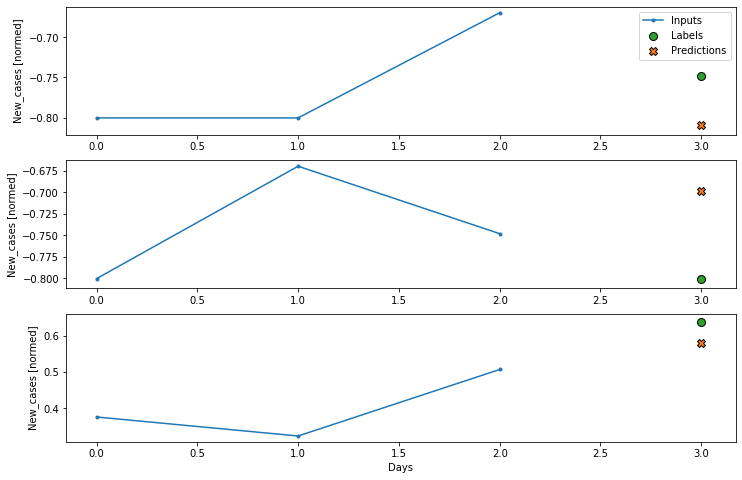

In [38]:
conv_window.plot(multi_step_dense)

In [39]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [40]:
history = compile_and_fit(lstm_model, wide_window)

Epoch 1/20
4/4 [==============================] - 0s 100ms/step - loss: 1.0254 - mean_absolute_error: 0.7254 - val_loss: 0.4129 - val_mean_absolute_error: 0.6378
Epoch 2/20
4/4 [==============================] - 0s 24ms/step - loss: 0.9516 - mean_absolute_error: 0.6874 - val_loss: 0.3510 - val_mean_absolute_error: 0.5846
Epoch 3/20
4/4 [==============================] - 0s 24ms/step - loss: 0.8968 - mean_absolute_error: 0.6610 - val_loss: 0.3026 - val_mean_absolute_error: 0.5379
Epoch 4/20
4/4 [==============================] - 0s 21ms/step - loss: 0.8515 - mean_absolute_error: 0.6378 - val_loss: 0.2560 - val_mean_absolute_error: 0.4872
Epoch 5/20
4/4 [==============================] - 0s 21ms/step - loss: 0.8150 - mean_absolute_error: 0.6150 - val_loss: 0.2173 - val_mean_absolute_error: 0.4390
Epoch 6/20
4/4 [==============================] - 0s 18ms/step - loss: 0.7826 - mean_absolute_error: 0.5955 - val_loss: 0.1990 - val_mean_absolute_error: 0.4138
Epoch 7/20
4/4 [=================

In [41]:
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

1/1 [==============================] - 0s 854us/step - loss: 0.1334 - mean_absolute_error: 0.3087


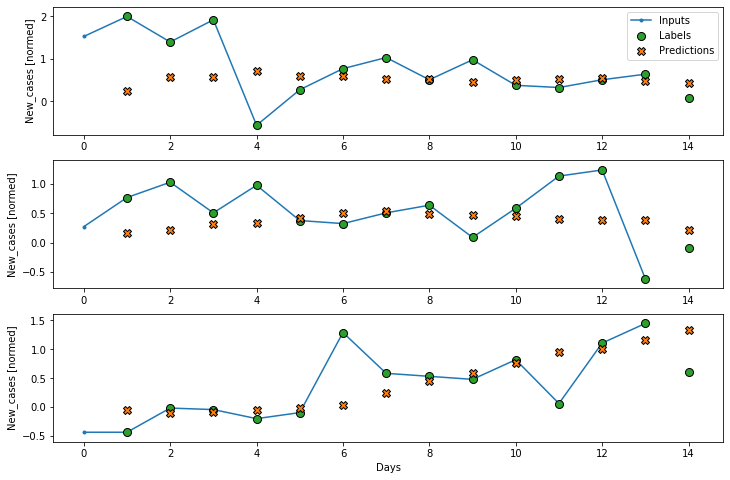

In [42]:
wide_window.plot(lstm_model)

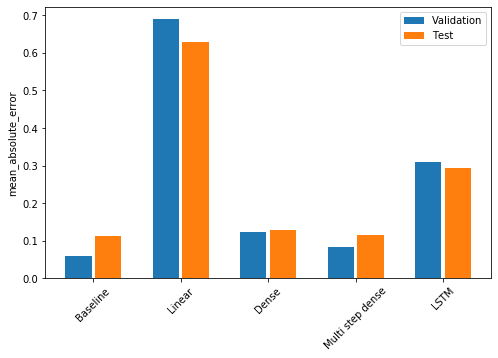

In [43]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.figure(figsize=(8,5))
plt.ylabel('mean_absolute_error')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.legend()
plt.show()

### Multi-output

In [44]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=14, label_width=14, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 14, 2)
Labels shape (batch, time, features): (32, 14, 2)


In [45]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [46]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

1/1 [==============================] - 0s 1ms/step - loss: 0.0400 - mean_absolute_error: 0.1137


In [47]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [48]:
history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
4/4 [==============================] - 0s 49ms/step - loss: 1.0719 - mean_absolute_error: 0.7821 - val_loss: 0.4674 - val_mean_absolute_error: 0.6629
Epoch 2/20
4/4 [==============================] - 0s 18ms/step - loss: 0.9402 - mean_absolute_error: 0.7199 - val_loss: 0.3782 - val_mean_absolute_error: 0.5921
Epoch 3/20
4/4 [==============================] - 0s 17ms/step - loss: 0.8379 - mean_absolute_error: 0.6670 - val_loss: 0.3000 - val_mean_absolute_error: 0.5224
Epoch 4/20
4/4 [==============================] - 0s 20ms/step - loss: 0.7593 - mean_absolute_error: 0.6168 - val_loss: 0.2340 - val_mean_absolute_error: 0.4565
Epoch 5/20
4/4 [==============================] - 0s 20ms/step - loss: 0.6865 - mean_absolute_error: 0.5728 - val_loss: 0.1744 - val_mean_absolute_error: 0.3870
Epoch 6/20
4/4 [==============================] - 0s 19ms/step - loss: 0.6293 - mean_absolute_error: 0.5290 - val_loss: 0.1274 - val_mean_absolute_error: 0.3264
Epoch 7/20
4/4 [==================

In [49]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/20
3/3 [==============================] - 1s 183ms/step - loss: 1.4178 - mean_absolute_error: 0.9045 - val_loss: 0.8512 - val_mean_absolute_error: 0.9100
Epoch 2/20
3/3 [==============================] - 0s 35ms/step - loss: 1.3240 - mean_absolute_error: 0.8697 - val_loss: 0.7882 - val_mean_absolute_error: 0.8749
Epoch 3/20
3/3 [==============================] - 0s 39ms/step - loss: 1.2351 - mean_absolute_error: 0.8359 - val_loss: 0.7297 - val_mean_absolute_error: 0.8407
Epoch 4/20
3/3 [==============================] - 0s 33ms/step - loss: 1.1558 - mean_absolute_error: 0.8039 - val_loss: 0.6761 - val_mean_absolute_error: 0.8078
Epoch 5/20
3/3 [==============================] - 0s 38ms/step - loss: 1.0809 - mean_absolute_error: 0.7715 - val_loss: 0.6258 - val_mean_absolute_error: 0.7755
Epoch 6/20
3/3 [==============================] - 0s 37ms/step - loss: 1.0121 - mean_absolute_error: 0.7413 - val_loss: 0.5778 - val_mean_absolute_error: 0.7431
Epoch 7/20
3/3 [=================

In [50]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each timestep is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [51]:
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros)
]))

history = compile_and_fit(residual_lstm, wide_window)

val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)

Epoch 1/20
3/3 [==============================] - 0s 120ms/step - loss: 0.8307 - mean_absolute_error: 0.5257 - val_loss: 0.0436 - val_mean_absolute_error: 0.1241
Epoch 2/20
3/3 [==============================] - 0s 36ms/step - loss: 0.8288 - mean_absolute_error: 0.5259 - val_loss: 0.0436 - val_mean_absolute_error: 0.1257
Epoch 3/20
3/3 [==============================] - 0s 25ms/step - loss: 0.8267 - mean_absolute_error: 0.5261 - val_loss: 0.0436 - val_mean_absolute_error: 0.1274
Epoch 4/20
1/1 [==============================] - 0s 897us/step - loss: 0.0437 - mean_absolute_error: 0.1292


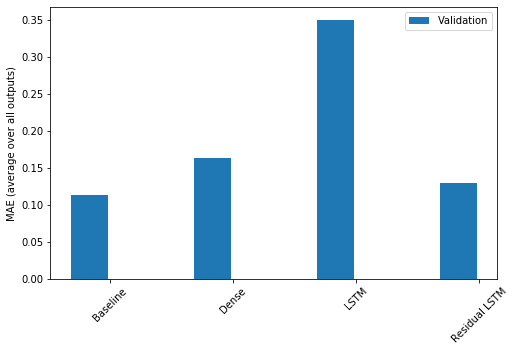

In [53]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
#test_mae = [v[metric_index] for v in performance.values()]

plt.figure(figsize=(8,5))
plt.bar(x - 0.17, val_mae, width, label='Validation')
#plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
plt.legend()
plt.show()

## Multi-step

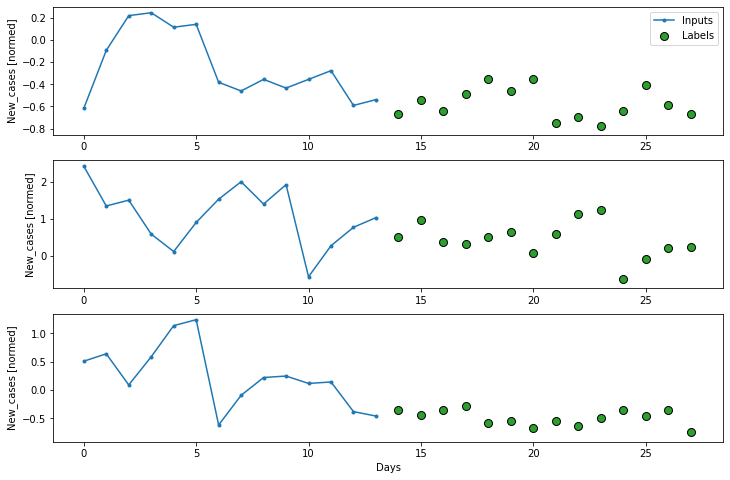

Total window size: 28
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label indices: [14 15 16 17 18 19 20 21 22 23 24 25 26 27]
Label column name(s): None

In [54]:
OUT_STEPS = 14
multi_window = WindowGenerator(input_width=14,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

1/1 [==============================] - 0s 1ms/step - loss: 0.0282 - mean_absolute_error: 0.0921


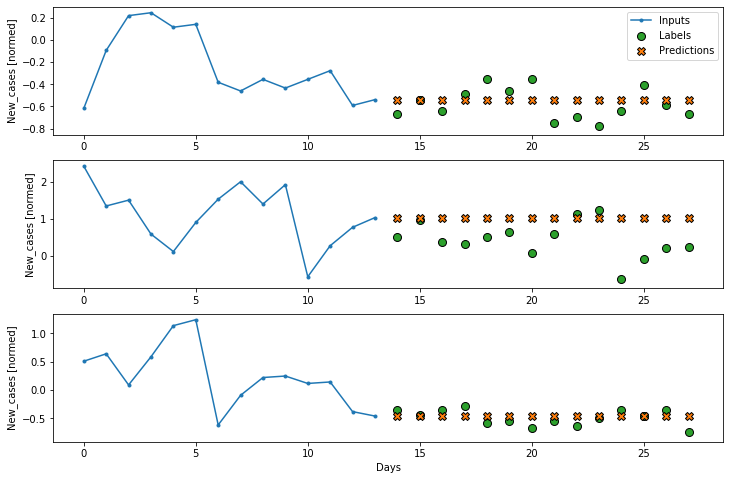

In [55]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

1/1 [==============================] - 0s 894us/step - loss: 0.0513 - mean_absolute_error: 0.1356


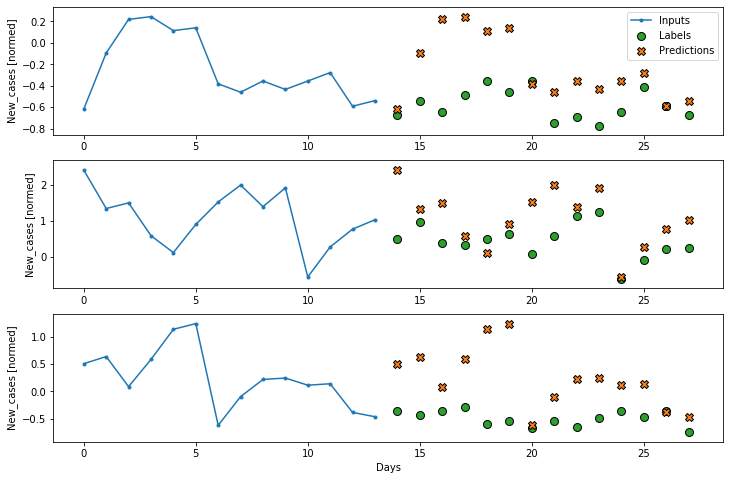

In [56]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

### Single shot

Epoch 1/20
3/3 [==============================] - 0s 47ms/step - loss: 1.1210 - mean_absolute_error: 0.7671 - val_loss: 0.5875 - val_mean_absolute_error: 0.7532
Epoch 2/20
3/3 [==============================] - 0s 20ms/step - loss: 1.1150 - mean_absolute_error: 0.7650 - val_loss: 0.5860 - val_mean_absolute_error: 0.7522
Epoch 3/20
3/3 [==============================] - 0s 23ms/step - loss: 1.1091 - mean_absolute_error: 0.7628 - val_loss: 0.5841 - val_mean_absolute_error: 0.7509
Epoch 4/20
3/3 [==============================] - 0s 22ms/step - loss: 1.1034 - mean_absolute_error: 0.7607 - val_loss: 0.5824 - val_mean_absolute_error: 0.7498
Epoch 5/20
3/3 [==============================] - 0s 18ms/step - loss: 1.0976 - mean_absolute_error: 0.7586 - val_loss: 0.5807 - val_mean_absolute_error: 0.7486
Epoch 6/20
3/3 [==============================] - 0s 17ms/step - loss: 1.0923 - mean_absolute_error: 0.7566 - val_loss: 0.5790 - val_mean_absolute_error: 0.7474
Epoch 7/20
3/3 [==================

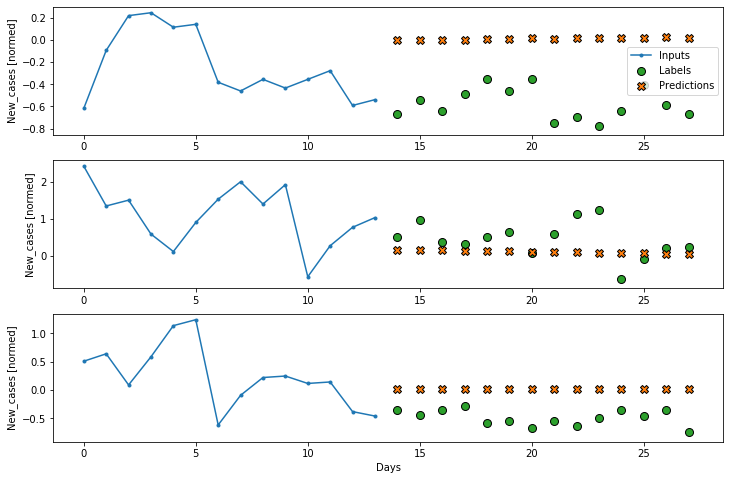

In [57]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

Epoch 1/20
3/3 [==============================] - 0s 62ms/step - loss: 1.1094 - mean_absolute_error: 0.7618 - val_loss: 0.5513 - val_mean_absolute_error: 0.7286
Epoch 2/20
3/3 [==============================] - 0s 28ms/step - loss: 1.0523 - mean_absolute_error: 0.7376 - val_loss: 0.5110 - val_mean_absolute_error: 0.7000
Epoch 3/20
3/3 [==============================] - 0s 22ms/step - loss: 1.0020 - mean_absolute_error: 0.7162 - val_loss: 0.4690 - val_mean_absolute_error: 0.6684
Epoch 4/20
3/3 [==============================] - 0s 20ms/step - loss: 0.9462 - mean_absolute_error: 0.6929 - val_loss: 0.4186 - val_mean_absolute_error: 0.6281
Epoch 5/20
3/3 [==============================] - 0s 21ms/step - loss: 0.8966 - mean_absolute_error: 0.6720 - val_loss: 0.3700 - val_mean_absolute_error: 0.5856
Epoch 6/20
3/3 [==============================] - 0s 21ms/step - loss: 0.8558 - mean_absolute_error: 0.6555 - val_loss: 0.3193 - val_mean_absolute_error: 0.5367
Epoch 7/20
3/3 [==================

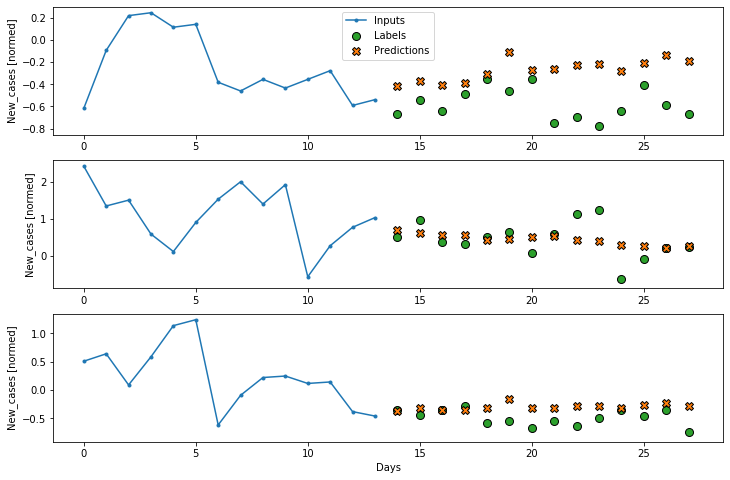

In [58]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

Epoch 1/20
3/3 [==============================] - 0s 118ms/step - loss: 1.1202 - mean_absolute_error: 0.7667 - val_loss: 0.5820 - val_mean_absolute_error: 0.7496
Epoch 2/20
3/3 [==============================] - 0s 18ms/step - loss: 1.1084 - mean_absolute_error: 0.7619 - val_loss: 0.5740 - val_mean_absolute_error: 0.7441
Epoch 3/20
3/3 [==============================] - 0s 20ms/step - loss: 1.0954 - mean_absolute_error: 0.7566 - val_loss: 0.5637 - val_mean_absolute_error: 0.7371
Epoch 4/20
3/3 [==============================] - 0s 19ms/step - loss: 1.0794 - mean_absolute_error: 0.7499 - val_loss: 0.5519 - val_mean_absolute_error: 0.7289
Epoch 5/20
3/3 [==============================] - 0s 20ms/step - loss: 1.0624 - mean_absolute_error: 0.7427 - val_loss: 0.5382 - val_mean_absolute_error: 0.7193
Epoch 6/20
3/3 [==============================] - 0s 19ms/step - loss: 1.0383 - mean_absolute_error: 0.7328 - val_loss: 0.5224 - val_mean_absolute_error: 0.7081
Epoch 7/20
3/3 [=================

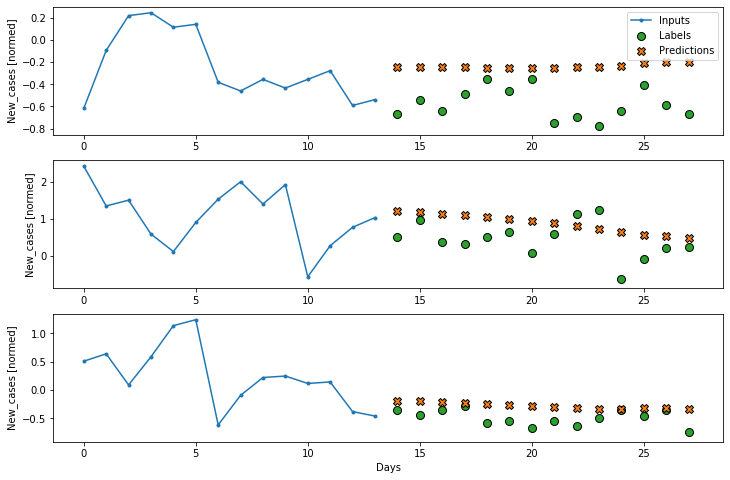

In [59]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

## AR model

In [60]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [61]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [62]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [63]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 2])

In [64]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

Epoch 1/20
3/3 [==============================] - 1s 208ms/step - loss: 1.0653 - mean_absolute_error: 0.7419 - val_loss: 0.4633 - val_mean_absolute_error: 0.6585
Epoch 2/20
3/3 [==============================] - 0s 22ms/step - loss: 1.0057 - mean_absolute_error: 0.7191 - val_loss: 0.4377 - val_mean_absolute_error: 0.6355
Epoch 3/20
3/3 [==============================] - 0s 25ms/step - loss: 0.9444 - mean_absolute_error: 0.6985 - val_loss: 0.4096 - val_mean_absolute_error: 0.6086
Epoch 4/20
3/3 [==============================] - 0s 22ms/step - loss: 0.8851 - mean_absolute_error: 0.6823 - val_loss: 0.3811 - val_mean_absolute_error: 0.5803
Epoch 5/20
3/3 [==============================] - 0s 26ms/step - loss: 0.8292 - mean_absolute_error: 0.6671 - val_loss: 0.3559 - val_mean_absolute_error: 0.5553
Epoch 6/20
3/3 [==============================] - 0s 24ms/step - loss: 0.7995 - mean_absolute_error: 0.6611 - val_loss: 0.3350 - val_mean_absolute_error: 0.5343
Epoch 7/20
3/3 [=================

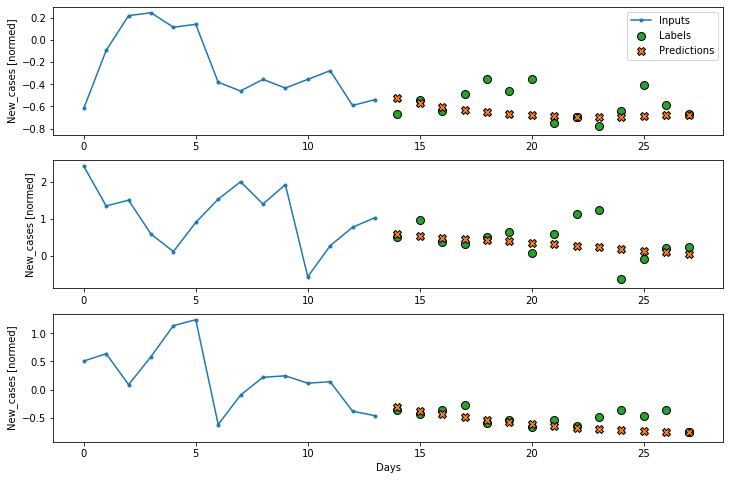

In [65]:
history = compile_and_fit(feedback_model, multi_window)

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

In [66]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

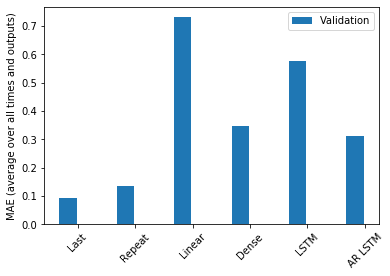

In [68]:
plt.bar(x - 0.17, val_mae, width, label='Validation')
#plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
plt.legend()
plt.show()